# Notebook of temperature cut for projected emission measure

### Dustin Nguyen 
### 29 June 2023 

In [1]:
import h5py
import numpy as np
import matplotlib
import yt 
import cmasher as cmr 
from mpl_toolkits.axes_grid1 import AxesGrid

matplotlib.rcParams['mathtext.default']='regular'
matplotlib.rcParams['xtick.direction']='in'

matplotlib.rcParams['ytick.direction']='in'
matplotlib.rcParams['xtick.top']=True
matplotlib.rcParams['ytick.right']=True
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import pyatomdb as padb 
from scipy import interpolate 
from scipy.integrate import solve_ivp, odeint, trapz, quad
from scipy.optimize import newton, brentq


from matplotlib import rc
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator, LogLocator

#matplotlib.font_manager._rebuild()

rc('font', family='serif')
rc('text', usetex=True)
params =   {'font.size' : 12,
                'text.usetex' : True,
                'xtick.major.size': 6,
                'ytick.major.size': 6,
                'xtick.minor.size': 3,
                'ytick.minor.size': 3,
                }
plt.rcParams.update(params)

mu   = 0.6
g    = 5/3
mp   = 1.672622e-24
kb   = 1.380658e-16
pc   = 3.08567758e18       # [cm]      pc 
kpc  = 3.08567758e21       # [cm]      kiloparsec
Msun = 1.98855e33          # [g]       solar mass
yr   = 3.15569e7           # [s]       year
kyr  = yr * 1e3

In [2]:
# Dimensions of plot, length of x and z simulations domain in kpc (y=0 slice)
# Construction of 3D grid too. 
xlen = 6.0
ylen = 6.0 
zlen = 6.0

x_cen = xlen / 2.0 * kpc 
y_cen = ylen / 2.0 * kpc 
z_cen = zlen / 2.0 * kpc 

nx = 512
ny = 512
nz = 512

x = np.linspace(0,xlen,nx) * kpc
y = np.linspace(0,ylen,ny) * kpc
z = np.linspace(0,zlen,nz) * kpc

# Generate the grid and then the shifted positions 
xm, ym, zm = np.meshgrid(x,y,z,indexing='ij')
xS, yS, zS = xm - x_cen, ym - y_cen, zm - z_cen

# Generate spherical coordinates on cartesian grid 
r_sph     = np.sqrt(xS**2 + yS**2 + zS**2 )
theta_sph = np.arctan2(np.sqrt(xS**2 + yS**2), zS)
phi_sph   = np.arctan2(yS, xS) 

number = 0

datapath_a = '/Users/dustin/Desktop/cholla_simulations/2023/mass-loading/spherical_data/2022_512cubed_sims/'

# number of the h5 file
h5n_a = 80

for i in np.arange(0,number+1,1):
    # DATA [A] 
    DE = 1 
    SCALAR = 1
    f_a = h5py.File(datapath_a+'mli_b_'+str(h5n_a)+'.h5', 'r')
    head_a = f_a.attrs
    nx = head_a['dims'][0]
    ny = head_a['dims'][1]
    nz = head_a['dims'][2]
    gamma = head_a['gamma'][0]
    dunit = head_a['density_unit']
    vunit = head_a['velocity_unit']
    punit = head_a['energy_unit']
    d_a  = np.array(f_a['density'])      # mass density
    mx_a = np.array(f_a['momentum_x'])   # x-momentum
    my_a = np.array(f_a['momentum_y'])   # y-momentum
    mz_a = np.array(f_a['momentum_z'])   # z-momentum
    E_a  = np.array(f_a['Energy'])       # total energy density
    vx_a = mx_a/d_a
    vy_a = my_a/d_a
    vz_a = mz_a/d_a
    if DE:
        e_a  = np.array(f_a['GasEnergy'])
        p_a  = e_a*(gamma-1.0)
        ge_a = e_a/d_a
    else:
        p_a  = (E_a - 0.5*d_a*(vx_a*vx_a + vy_a*vy_a + vz_a*vz_a)) * (gamma - 1.0)
        ge_a  = p_a/d_a/(gamma - 1.0)
    if SCALAR:
        s_a  = np.array(f_a['scalar0'])/d_a 
        
     # CGS units here    
    n_a     = d_a*dunit / (0.6 * mp)
    rho_a   = n_a * 0.6 * mp
    vx_a    = vx_a*vunit
    vy_a    = vy_a*vunit
    vz_a    = vz_a*vunit
    vmag_a  = np.sqrt(vx_a**2 + vy_a**2 + vz_a**2)
    p_a     = p_a*punit
    T_a     = p_a / (n_a*kb)
    cs_a = np.sqrt(gamma*(p_a)/(n_a*0.6*mp))
    M_a = vmag_a / cs_a 
    

### Make temperature cut by doing a for-loop through the entire volume and retaining material less than 2e4 K
### This is for illustrative purposes, we'll use a vectorized implementation below. 

In [ ]:
n_squared = n_a**2 
n_squared_temp_filtered = np.empty_like(n_squared)


# Loop through entire array, setting density of material that is greater than 2e4K to zero.
for k in np.arange(0,int(nz),1):
    for j in np.arange(0,int(ny),1):
        for i in np.arange(0,int(nx),1):
            if T_a[i,j,k] <= 2e4:
                n_squared_temp_filtered[i,j,k] = n_squared[i,j,k] 
            else:
                n_squared_temp_filtered[i,j,k] = 0

### The process below is vectorized version of the triple for-loop. It's signifigantly faster and returns the same values. 
### 7 lines of code -> 1 line of code

In [3]:
n_squared = n_a**2 
n_squared_temp_filtered_vectorized = n_squared.copy() # Make a copy of n_squared
n_squared_temp_filtered_vectorized[T_a > 2e4] = 0     # Set elements of n_squared_temp_filtered to 0 where corresponding T_a element is > 2e4


# We'll also grab the cut temperature plot, for illustrative purposes below. 

T_temp_filtered_vectorized = T_a.copy() # Make a copy of T 
T_temp_filtered_vectorized[T_a > 2e4] = 0 

print("maximum temperature of filtered array is: ", np.max(T_temp_filtered_vectorized), " K")

maximum temperature of filtered array is:  19999.90576768612  K


/var/folders/hz/wjg31ld52r9cp4r029dnh6vm0000gn/T/ipykernel_15908/2468246242.py:26: RuntimeWarning: divide by zero encountered in log10
  ax3.imshow(np.log10(n_squared_temp_filtered_vectorized[:,int(ny/2),:]),cmap=nlog_cmap)
/var/folders/hz/wjg31ld52r9cp4r029dnh6vm0000gn/T/ipykernel_15908/2468246242.py:27: RuntimeWarning: divide by zero encountered in log10
  ax4.imshow(np.log10(T_temp_filtered_vectorized[:,int(ny/2),:]),cmap=Tlog_cmap)


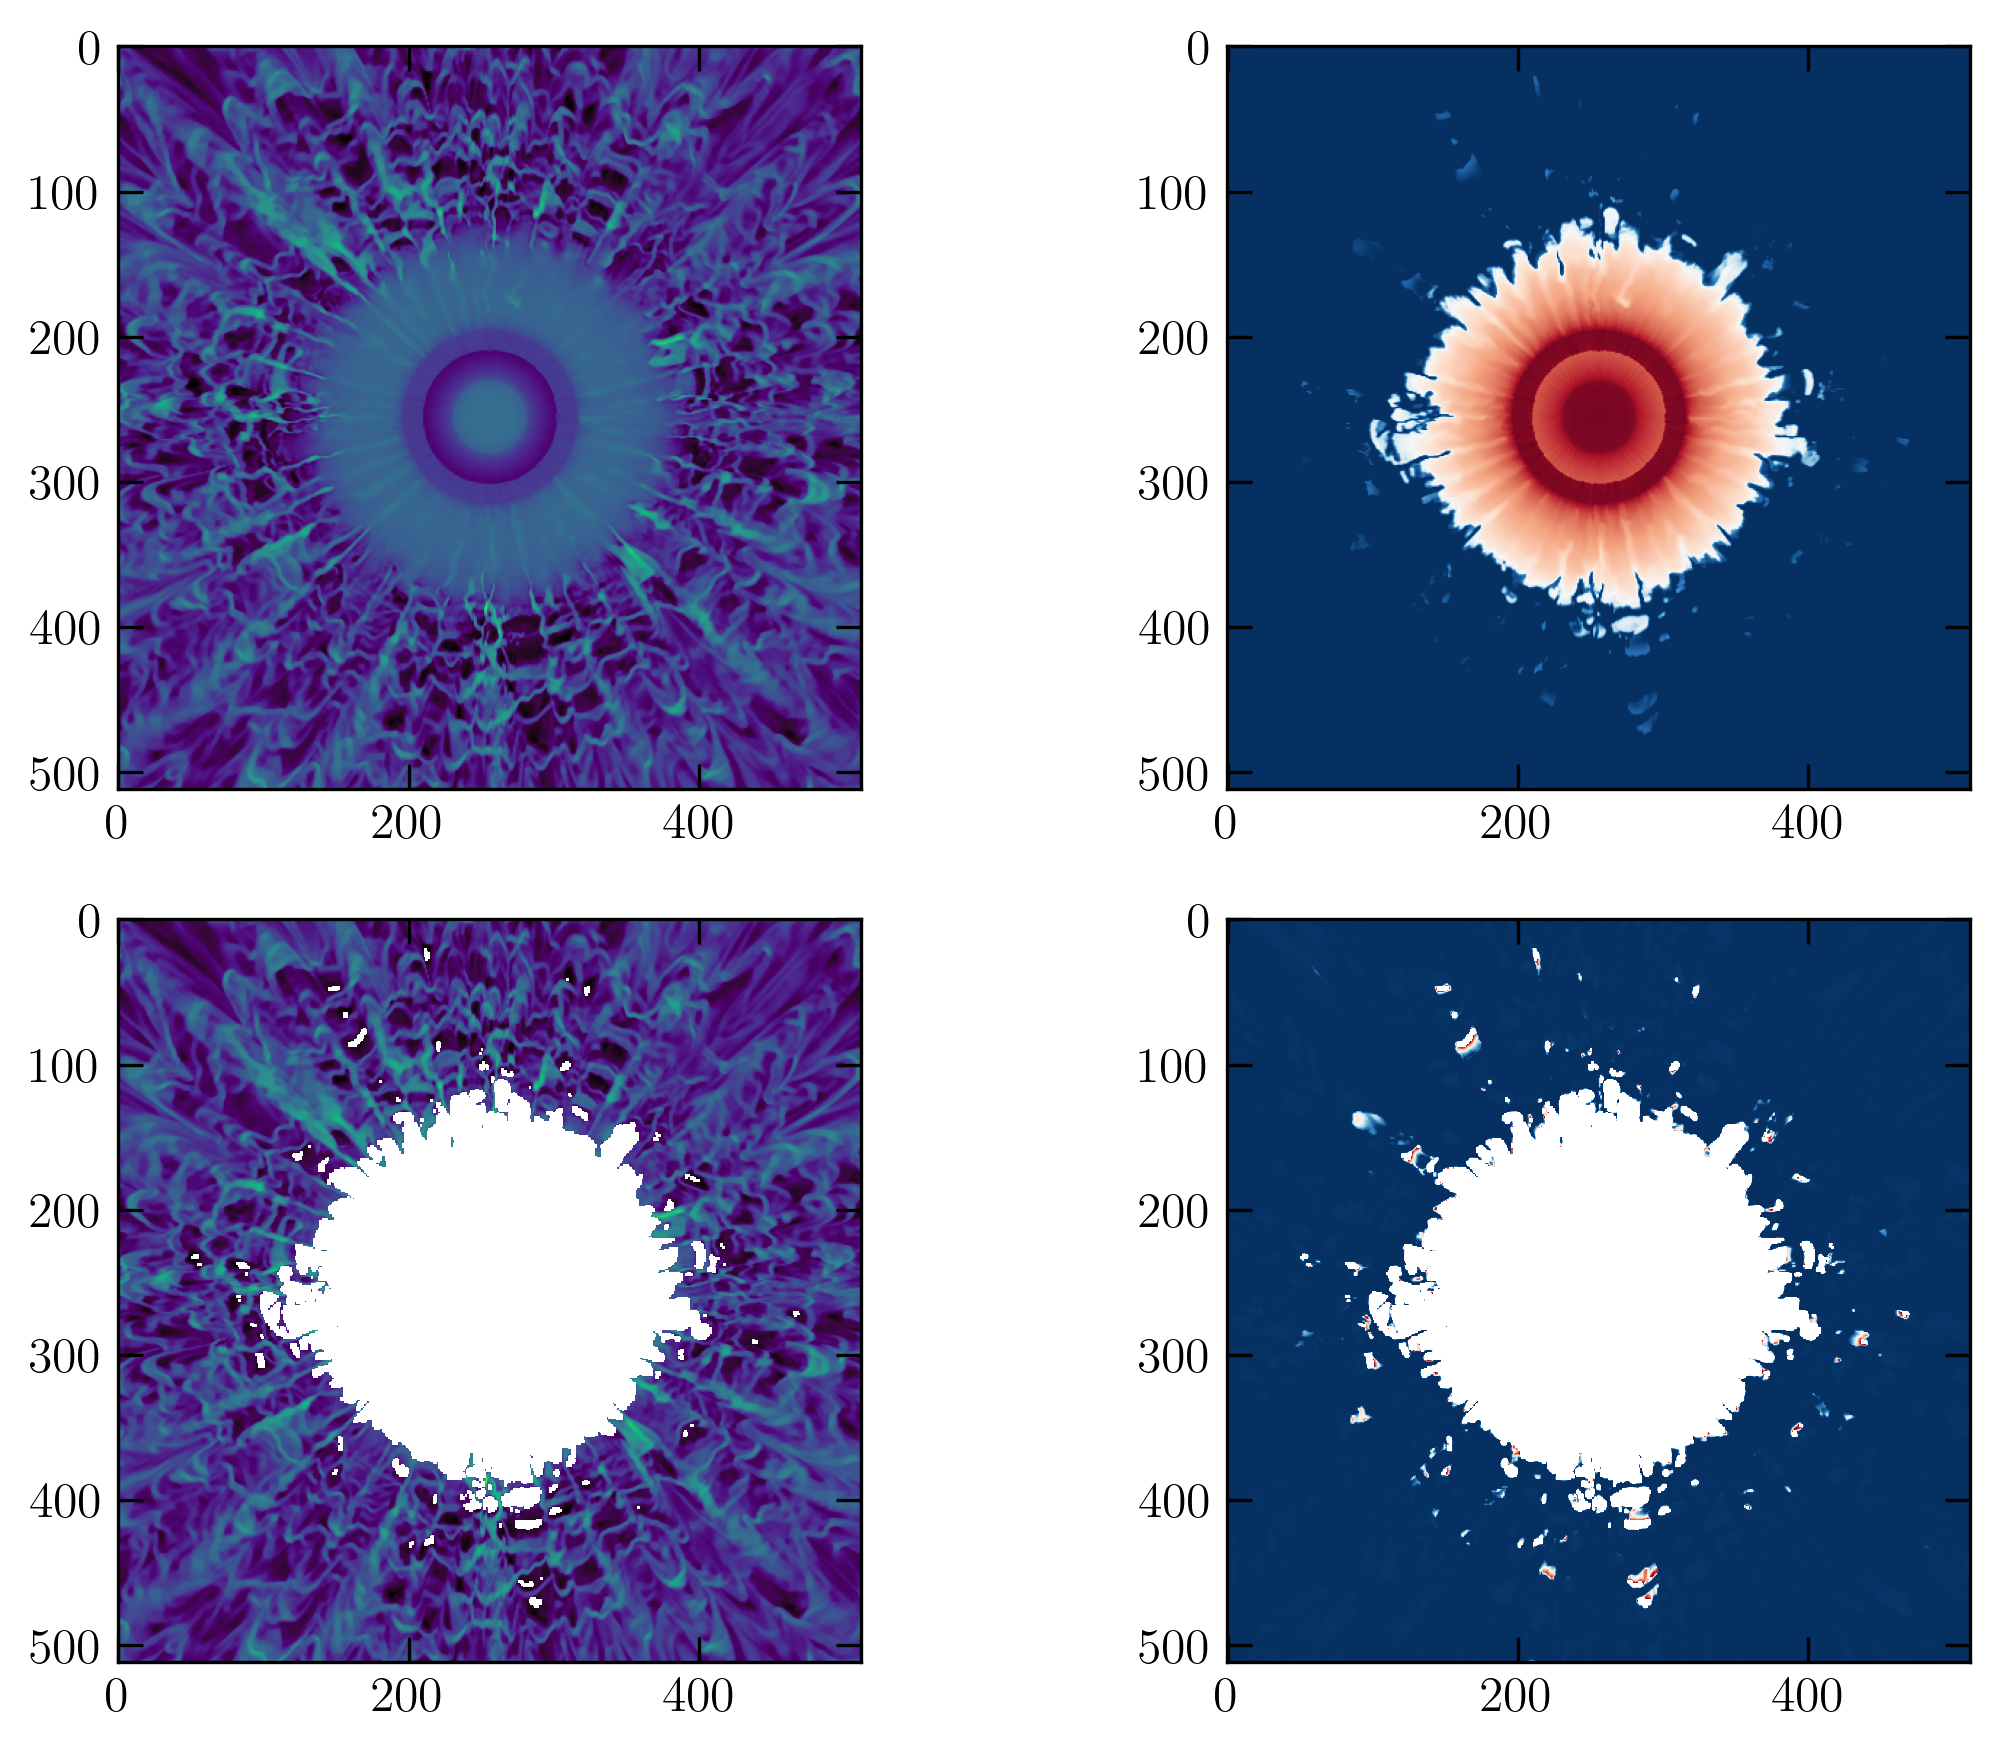

In [4]:
fig = plt.figure(dpi=300,figsize=(8,6))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)


nlog_min = -3 
nlog_max = 2 
nlog_ticks = [-3,-2,-1,0,1,2]
nlog_ticklabels = ['-3','-2','-1','0','1','2']
nlog_cmap = cmr.lavender 


Tlog_min = 4 
Tlog_max = 8 
Tlog_ticks = [4,5,6,7,8]
Tlog_ticklabels = ['4','5','6','7','8']
Tlog_cmap = "RdBu_r"




ax1.imshow(np.log10(n_a[:,int(ny/2),:]),cmap=nlog_cmap)
ax2.imshow(np.log10(T_a[:,int(ny/2),:]),cmap=Tlog_cmap)
ax3.imshow(np.log10(n_squared_temp_filtered_vectorized[:,int(ny/2),:]),cmap=nlog_cmap)
ax4.imshow(np.log10(T_temp_filtered_vectorized[:,int(ny/2),:]),cmap=Tlog_cmap)

fig.tight_layout()

### Now we integrate through the y-axis by looping from the y and z planes to get the integrated emission measure. 

In [6]:
dx = xlen/nx
y_array   = np.arange(ny) * dx * kpc
base_shape = np.zeros( (nx,nz) )


const = 1 

n_squared_projected = np.empty_like( base_shape )
n_squared_times_constant_projected = np.empty_like( base_shape )
for k in np.arange(0,int(nz),1):
    for i in np.arange(0,int(nx),1):
        n_squared_projected[i,k] = np.trapz(n_squared_temp_filtered_vectorized[i,:,k],y_array)
        n_squared_times_constant_projected[i,k] = np.trapz(n_squared_temp_filtered_vectorized[i,:,k],y_array) * const

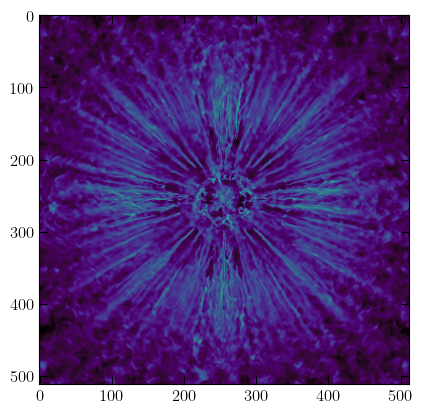

In [7]:
plt.imshow(np.log10(n_squared_projected),cmap=nlog_cmap)

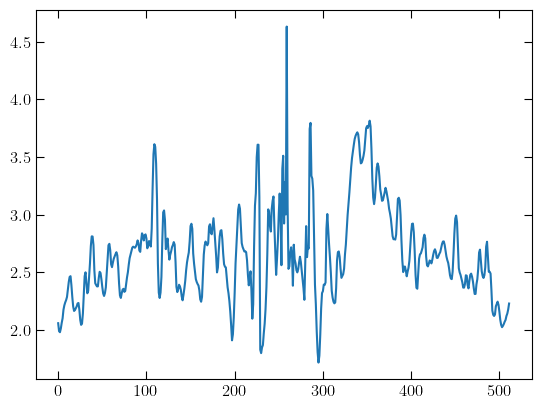

In [8]:
# We'll plot this skewer to get a rough estimate of the bounds for the color-map for plotting. 
# Conventional units divide by pc. 

plt.plot(np.log10(n_squared_projected[:,int(nz/2)]/pc))

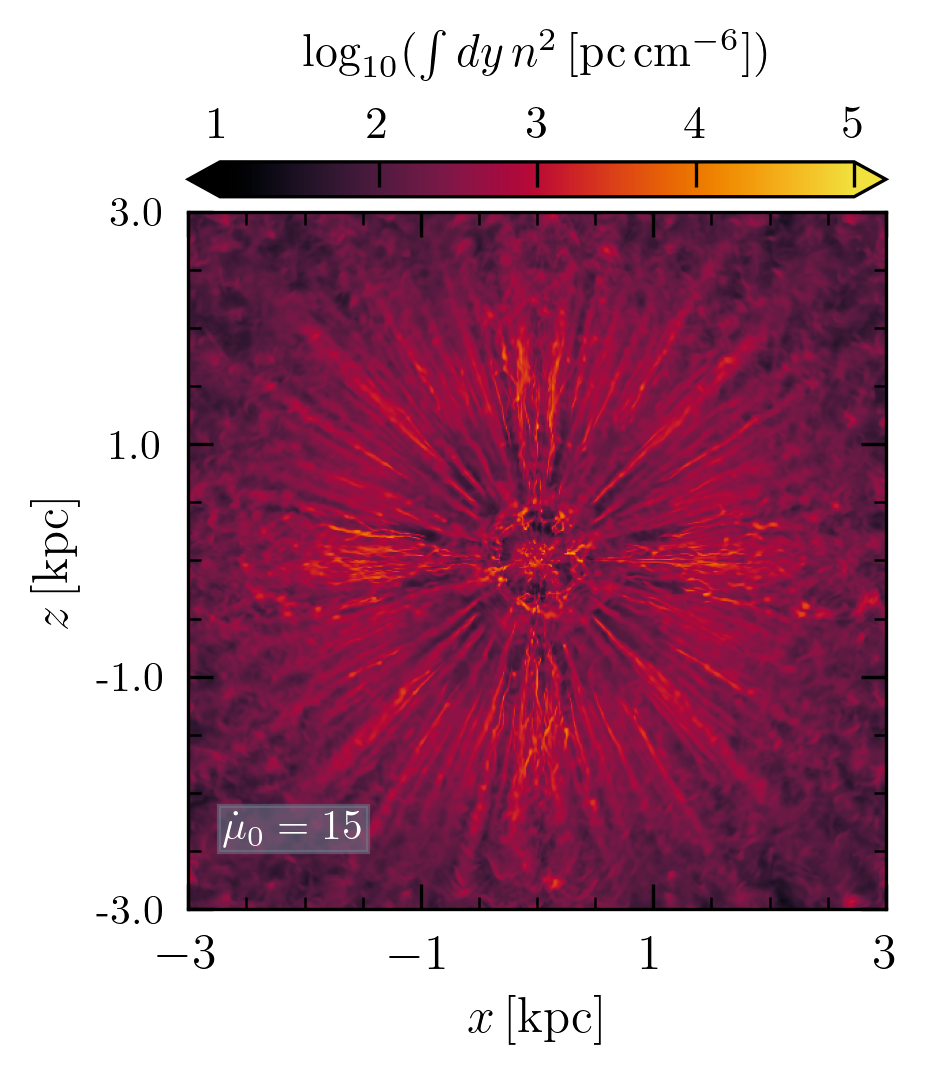

In [9]:
dticks = 2.0      # kpc 
xticks = np.arange((-xlen/2),(xlen/2)+dticks,dticks)
yticks = np.arange((-zlen/2),(zlen/2)+dticks,dticks)
dt = 0.25    # Myr ; 100 kyr 


fig = plt.figure(dpi=300,figsize=(3,5))
ax1 = fig.add_subplot(1,1,1)
plt.setp(ax1.get_yticklabels(), visible=True)
plt.setp(ax1.get_xticklabels(), visible=True)


# nlog squared here 
nlog_min = 1.0 
nlog_max = 5.0
nlog_ticks = [1,2,3,4,5]
nlog_ticklabels = ['1','2','3','4','5']
nlog_cmap = cmr.ember

label_height = 3.0

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size='5%', pad=0.05)
fig.add_axes(cax)
#text = ax1.annotate('$\\texttt{A0}$ ($\dot{\mu}_0=15$)', xy=(0.05,0.875), color='white',size=10,xycoords=ax1.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
text2 = ax1.annotate('$\dot{\mu}_0=15$', xy=(0.05,0.1), color='white',size=10,xycoords=ax1.transAxes, bbox=dict(facecolor='slategray', edgecolor='slategray', alpha=0.5, pad=1.0))
im = ax1.imshow((np.log10(n_squared_projected[:,:]/pc)).T,cmap=nlog_cmap,origin='lower',extent=[-xlen/2,xlen/2,-zlen/2,zlen/2])
cbar=fig.colorbar(im,cax=cax,orientation ='horizontal',ticks=nlog_ticks,shrink=0.5,extend="both")
cbar.ax.set_xticklabels(nlog_ticklabels,rotation=0,size=11) 
cbar.ax.set_title('$\log_{10}(\int dy \, n^2 \,\mathrm{[  pc \, cm^{-6} ]})$', rotation=0, y=label_height,fontsize=11)
im.set_clim(nlog_min,nlog_max)  
#ax1.set_ylabel('$y\,$[kpc]')
cax.xaxis.set_ticks_position("top")
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_ylabel('$z\,$[kpc]')
ax1.set_xlabel('$x\,$[kpc]')
ax1.set_yticklabels(yticks,fontsize=10)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="minor",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)
ax1.tick_params(which="major",axis="both", direction="in", top='on',bottom ='on', left='on',right='on',pad=6)


plt.savefig('mudot015_nsquared_2e4Kfiltered.pdf',facecolor='white',pad_inches=0.01,bbox_inches='tight')


## Now for calculation of shattering and cooling lengths 

## $t_\mathrm{cool} = \frac{3}{2}  \frac{P} {n^2 \Lambda}$ 

## $l_\mathrm{shatter} = \mathrm{min}( c_s \ t_\mathrm{cool}) $ 

## $l_\mathrm{cool} = \mathrm{min} ( v \ t_\mathrm{cool})$ 

The cooling at T < 1e4 is 0, but here I replaced it with nan values to avoid the division by 0. 

In [10]:
# We will need a cooling curve. The only that we used in the Cholla simulation is the analytic version Evan uses. 

def Lambda_func(T):
    if T < 10**4:
        Lambda  = np.nan 
    elif 10**4 <= T and T < 10**(5.9):
        Lambda = 10**(-1.3*(np.log10(T)-5.25)**2-21.25)
    elif 10**(5.9) <= T and T < 10**(7.4):
        Lambda = 10**(0.7*(np.log10(T)-7.1)**2-22.8)
    elif 10**(7.4) <= T:
        Lambda = 10**(0.45*np.log10(T)-26.065)
    return Lambda
Lambda_func_vectorized = np.vectorize(Lambda_func,otypes=[float])

In [11]:
Lambda_a = Lambda_func_vectorized(T_a)

### Plot T and Lambda, Lambda should be for the cool material. 

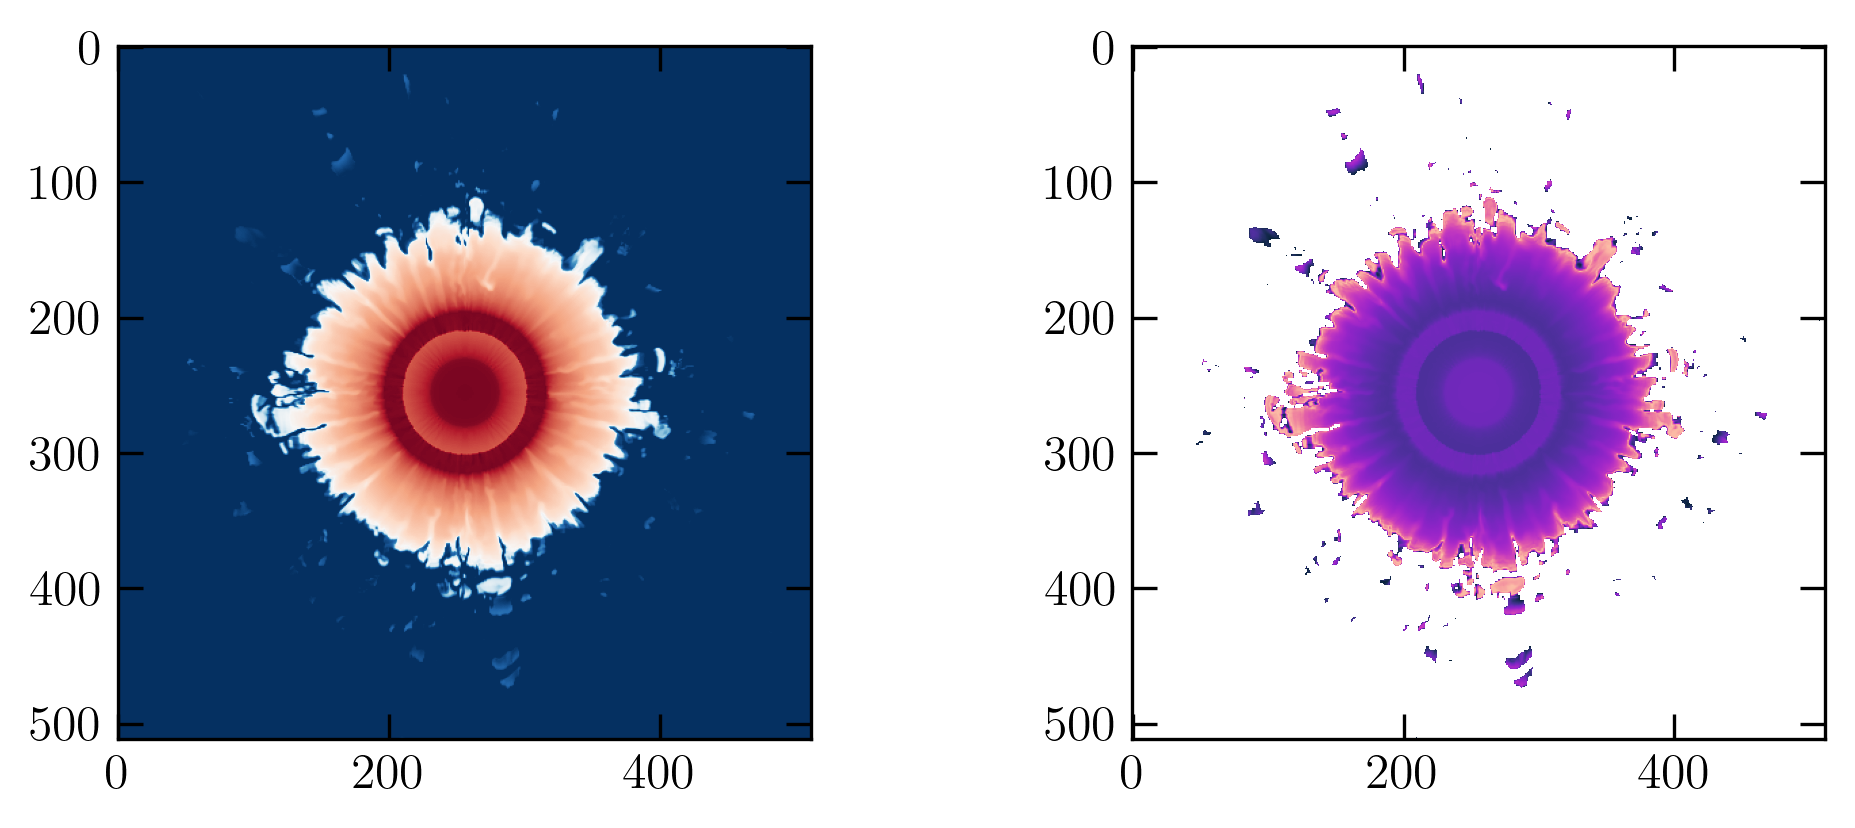

In [12]:
fig = plt.figure(dpi=300,figsize=(8,3))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.imshow(np.log10(T_a[:,int(ny/2),:]),cmap=Tlog_cmap)

ax2.imshow(np.log10(Lambda_a[:,int(ny/2),:]),cmap=cmr.bubblegum)

In [13]:
Tcool_a    = 3/2 * p_a / ( n_a**2 * Lambda_a)
lshatter_a =  cs_a * Tcool_a
lcool_a    =  vmag_a * Tcool_a

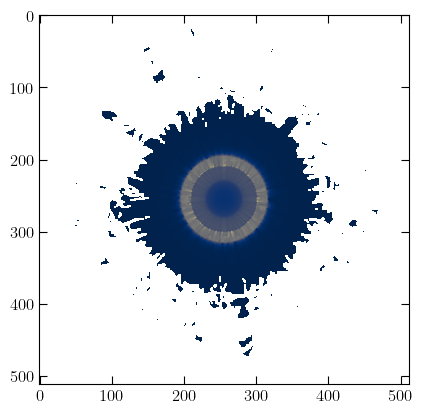

In [14]:
# As expected, the shattering lengths are smallest at the edges of the coolest material. 


plt.imshow(lshatter_a[:,int(ny/2),:],cmap='cividis')

In [15]:
print("l_shatter min in pc is : ", np.nanmin(lshatter_a/pc))
print("l_shatter max in kpc is : ", np.nanmax(lshatter_a/kpc))

l_shatter min in pc is :  0.03433483676080918
l_shatter max in kpc is :  371.1740587557992


In [16]:
print("l_cool min in pc is : ", np.nanmin(lcool_a/pc))
print("l_cool max in kpc is : ", np.nanmax(lcool_a/kpc))

l_cool min in pc is :  0.2639889148679635
l_cool max in kpc is :  290.5189324763597
